In [1]:
from __future__ import division
from importlib import reload
from modules import * 

import csv
import pickle
fig_savedir = '../data/figures/'

(7, 13)


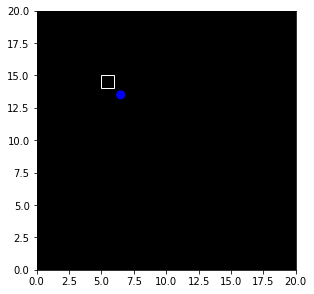

In [2]:
grid_params = {
    'y_height':     20, 
    'x_width':      20,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

gp.plot_env(maze)

In [3]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
    else:
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

    # make agent 
    agent_params = sg.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])

    run_dict = {
        'NUM_EVENTS':   300,
        'NUM_TRIALS':   2000,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

In [4]:
agent_params = {
        'load_model':   False,
        'load_dir':     '../data/outputs/gridworld/open_field{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       True,
        'cachelim':     100, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }

run_dict = reset_agt(agent_params)

In [5]:
expt.run_full_trials(run_dict, use_EC=True)

../memory/episodic.py:110: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / self.memory_envelope), 8)


[11:48:19]  Trial 1 TotRew = 1 (0.452s)
[11:49:32]  Trial 11 TotRew = 0 (73.150s)
[11:50:48]  Trial 21 TotRew = 0 (75.757s)
[11:52:03]  Trial 31 TotRew = 0 (75.354s)
[11:53:15]  Trial 41 TotRew = 0 (71.984s)


KeyboardInterrupt: 

In [8]:
print(len(agent_params['EC'].cache_list))

95


In [ ]:
ac.torch.save(MF,agent_params['load_dir'])